In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
log_train=  pd.read_csv('SP500/log_train_CNN_adjusted learning rate.csv')

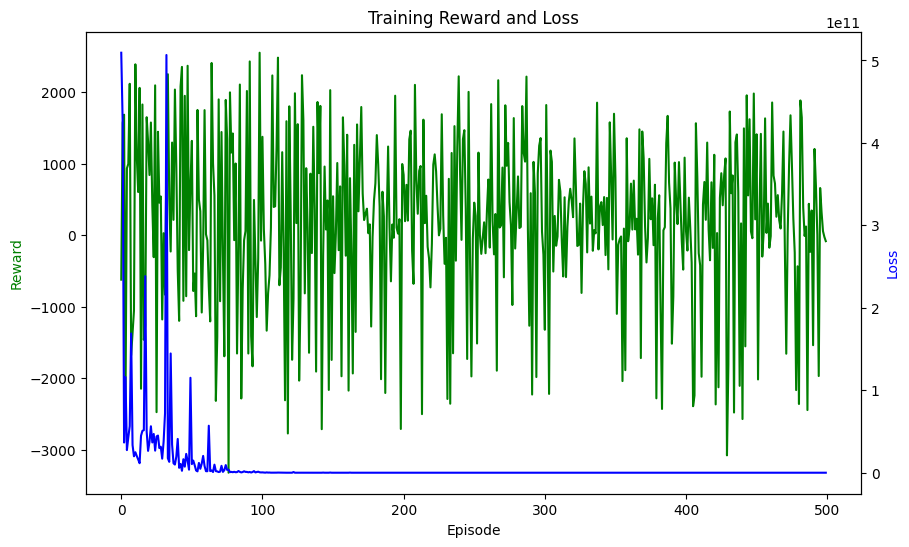

In [5]:
def plot_training(log_train):
    #for every Episode, Reward is the last value minus the first value
    df = log_train.groupby('Episode')[['Reward']].apply(lambda x: x.iloc[-1] - x.iloc[0]).reset_index()
    df_2 = log_train.groupby('Episode')[['Loss']].mean()
    df_1 = pd.merge(df, df_2, on='Episode')
    #plot the data on dual axis
    fig, ax1 = plt.subplots(figsize=(10,6))
    ax2 = ax1.twinx()
    ax1.plot(df_1['Reward'], color='g')
    ax2.plot(df_1['Loss'], color='b')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward', color='g')
    ax2.set_ylabel('Loss', color='b')
    plt.title('Training Reward and Loss')
    plt.show()

plot_training(log_train)

In [8]:
import pandas as pd

def train_agent(agent, states, episodes, batch_size):
    Episode = []
    Time = []
    Reward = []
    Total_Reward = []
    Action = []
    next_price = []
    prev_price = []
    loss_per_episode = []

    for e in range(episodes):
        state = states[0]
        reward = 0
        last_action = 'Hold'
        days_since_last_buy = 0
        has_open_position = False  # Track if there's an open position
        
        for time in range(1, len(states)):
            action = agent.act(state)

            # Ensure sell only after buy and max 11 days between buy and sell
            if has_open_position:
                days_since_last_buy += 1

            if action == 0:  # Sell
                if not has_open_position:  # Can't sell if no open position
                    action = 2  # Change to Hold if not previously bought
                else:
                    has_open_position = False  # Sell the open position
                    days_since_last_buy = 0  # Reset days since last buy
                    reward += state[-1][3]  # Example: Reward based on price difference

            if action == 1:  # Buy
                if has_open_position:  # Can't buy if already have an open position
                    action = 2  # Change to Hold if already bought
                else:
                    has_open_position = True  # Buy, opening a new position
                    days_since_last_buy = 0  # Reset days since last buy
                    reward -= state[-1][3]  # Example: Reward based on price difference

            # Force a sell if more than 11 days since last buy
            if has_open_position and days_since_last_buy > 11:
                action = 0  # Force a sell
                has_open_position = False
                days_since_last_buy = 0
                reward += state[-1][3]  # Example: Reward based on price difference

            # Update last action and reset days since last buy if sell or buy happens
            if action == 1:  # Buy
                days_since_last_buy = 0
                has_open_position = True
            if action == 0:  # Sell
                has_open_position = False
            if action == 2:  # Hold
                reward = reward  # Example: Reward based on price difference

            next_state = states[time]
            prev_price.append(state[-1][3])
            done = time == len(states) - 1
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            Episode.append(e+1)
            Time.append(time)
            Reward.append(reward)
            Action.append(action)
            if done:
                if (e+1) % 10 == 0:
                    print(f"Episode {e+1}/{episodes}, Total Reward: {reward}")
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        # Calculate the loss for the current episode and append it
        loss_per_episode.append(agent.loss_history[-1])

    log_train = pd.DataFrame({'Episode': Episode, 'Time': Time, 'Reward': Reward, 'Total_Reward': reward, 'Action': Action, 'Price': prev_price})
    log_train['Action'] = log_train['Action'].map({0: 'Sell', 1: 'Buy', 2: 'Hold'})
    log_train['Action'].value_counts()
    log_train['Loss'] = log_train['Episode'].map({index: element for index, element in enumerate(loss_per_episode, start=1)})

    # Plot loss per episode at the end of training
    agent.plot_loss_per_episode(loss_per_episode)
    return log_train


Reward: -1.0
